#***Leiden***

In [32]:
!pip install leidenalg
!pip install igraph

In [33]:
import pandas as pd
import networkx as nx
import random
import leidenalg as la
import igraph as ig
import sys
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [34]:
# Load the data from CSV
file_path = 'CDR_2.csv'  # Replace with your file path
try:
    df = pd.read_csv(file_path)
    print(df.head())
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check the file path.")
    sys.exit(1)
except pd.errors.ParserError:
    print(f"Error: Could not parse the CSV file. Please ensure it is properly formatted.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    sys.exit(1)

   Calling Party  Called Party             IMEI             IMSI   Call Date  \
0     7236711311    7083102919  486014913456364  680691865878286  2025-01-13   
1     7236711311    9744857269  486014913456364  680691865878286  2025-01-22   
2     7236711311    9707895068  486014913456364  680691865878286  2025-01-14   
3     7236711311    9744857269  486014913456364  680691865878286  2025-01-11   
4     7236711311    9707895068  486014913456364  680691865878286  2025-01-09   

     Call Type Start Time  End Time  Duration (seconds)  
0     Voice In   13:12:52  15:04:23                6691  
1     Voice In   02:27:46  02:59:44                1918  
2  Missed Call   04:08:43       NaN                   0  
3     Voice In   18:36:49  18:47:52                 663  
4       SMS In   12:44:56       NaN                   0  


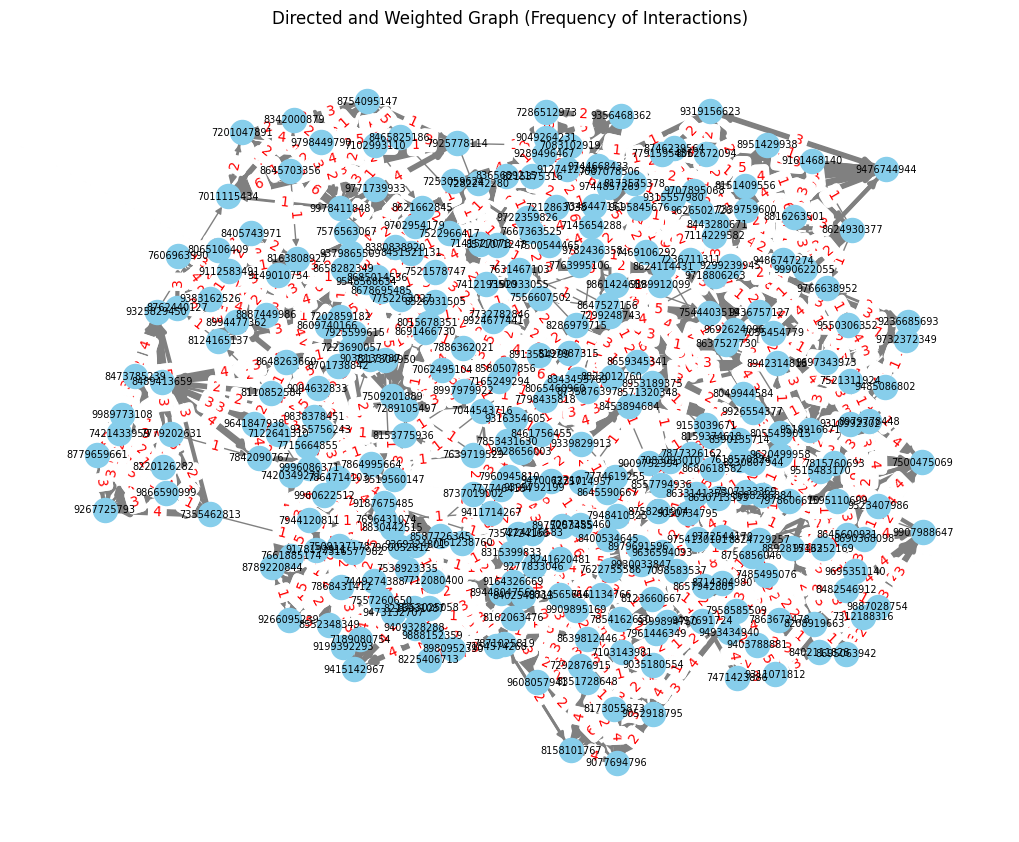

In [35]:
# Creating a Directed Graph (weighted by frequency of calls or SMS)
G = nx.DiGraph()

try:
    # Compute frequency of interactions (calls + SMS) between each pair
    interaction_counts = df.groupby(['Calling Party', 'Called Party']).size().reset_index(name='Frequency')

    # Adding directed edges with frequency as weights
    for _, row in interaction_counts.iterrows():
        G.add_edge(row['Calling Party'], row['Called Party'], weight=row['Frequency'])

    # Removing self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Visualizing the graph
    plt.figure(figsize=(10, 8))
    random.seed(50)
    pos = nx.kamada_kawai_layout(G)  # Position nodes using a force-directed algorithm
    weights = nx.get_edge_attributes(G, 'weight')

    # Create a list of edge widths based on weights
    widths = [weights[edge] for edge in G.edges()]

    # Draw the graph with varying edge widths
    nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", edge_color="gray", font_size=7, width=widths)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color="red")
    plt.title("Directed and Weighted Graph (Frequency of Interactions)")
    plt.show()

except KeyError as e:
    print(f"Error: Missing column in your CSV file: {e}. Please ensure 'Calling Party', 'Called Party', and 'Frequency' columns are present.")
    sys.exit(1)
except (TypeError, ValueError) as e:
    print(f"Error: Data type mismatch or unexpected value: {e}. Please check the data in your CSV file.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during graph creation: {e}")
    sys.exit(1)

In [36]:
# Converting NetworkX graph to igraph, including weights
try:
    edge_list = [(u, v, G[u][v]['weight']) for u, v in G.edges()]  # Include weights in edge list
except KeyError:
    print("Error: 'weight' attribute not found on all edges. Ensure all edges have weights.")
    sys.exit(1)  # Exit with error code 1
except Exception as e:
    print(f"An unexpected error occurred during edge list creation: {e}")
    sys.exit(1)

# Creating the igraph graph
try:
    ig_graph = ig.Graph.TupleList(edge_list, directed=True, edge_attrs=['weight'])  # Specify edge attribute
except Exception as e:
    print(f"Error creating igraph graph: {e}")
    sys.exit(1)

In [37]:
# Optimizing the graph with Leiden algorithm (using weights)
try:
    partition_leiden = la.find_partition(ig_graph, la.ModularityVertexPartition, weights='weight')  # Use weights
except Exception as e:
    print(f"Error during Leiden algorithm execution: {e}")
    sys.exit(1)

# Getting the communities from the Leiden algorithm
try:
    partition = {}
    for i, node in enumerate(ig_graph.vs):
        partition[node["name"]] = partition_leiden.membership[i]
except Exception as e:
    print(f"Error extracting communities from Leiden results: {e}")
    sys.exit(1)

# Computing the modularity score
try:
    modularity_score = partition_leiden.modularity
    print(f"Modularity Score : {modularity_score}")
except AttributeError:
    print("Error: 'modularity' attribute not found in Leiden results.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred while computing modularity: {e}")
    sys.exit(1)

Modularity Score : 0.9175547754219108


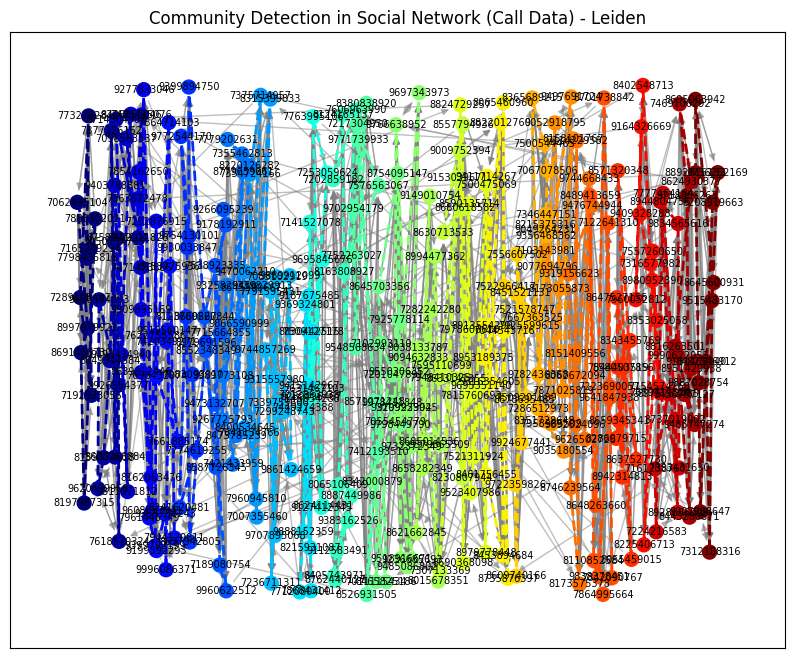

In [38]:
# Visualize the communities with improved layout
try:
    plt.figure(figsize=(10, 8))

    # Group nodes by community, starting from Community 1
    communities = {}
    for node, community_id in partition.items():
        # Adding 1 to the community_id to start from 1
        adjusted_community_id = community_id + 1

        if adjusted_community_id not in communities:
            communities[adjusted_community_id] = []
        communities[adjusted_community_id].append(node)

    # Adjusting positions within communities to gather nodes together
    adjusted_pos = {}

    # Increasing the proximity between nodes of the same community
    for community_id, nodes in communities.items():
        x_pos = [random.uniform(-1, 1) for _ in nodes]
        y_pos = [random.uniform(-1, 1) for _ in nodes]
        for node, x, y in zip(nodes, x_pos, y_pos):
            adjusted_pos[node] = (x + community_id * 1.5, y)

    # Nodes colored by community
    num_communities = len(communities)
    cmap = plt.cm.get_cmap('jet', num_communities)
    colors = [cmap(partition[node]) for node in G.nodes()]

    nx.draw_networkx_nodes(G, adjusted_pos, node_color=colors, cmap=plt.cm.jet, node_size=100)

    # Draw directed edges
    nx.draw_networkx_edges(G, adjusted_pos, alpha=0.5, edgelist=G.edges(), arrows=True, edge_color="grey")

    # Draw node labels
    nx.draw_networkx_labels(G, adjusted_pos, font_size=7, font_color="black")

    # Add community borders
    for community_id, nodes in communities.items():
        community_pos = [adjusted_pos[node] for node in nodes]
        x_coords, y_coords = zip(*community_pos)

        if nodes:
            try:
                node_index = list(G.nodes()).index(nodes[0])
                community_color = colors[node_index]
            except ValueError:
                community_color = 'black'
        else:
            community_color = 'black'

        line_style = '--'

        plt.gca().add_patch(plt.Polygon(list(zip(x_coords, y_coords)),
                                       fill=None,
                                       edgecolor=community_color,
                                       linestyle=line_style,
                                       lw=2))

    plt.title("Community Detection in Social Network (Call Data) - Leiden")
    plt.show()

except Exception as e:
    print(f"An error occurred during visualization: {e}")
    sys.exit(1)

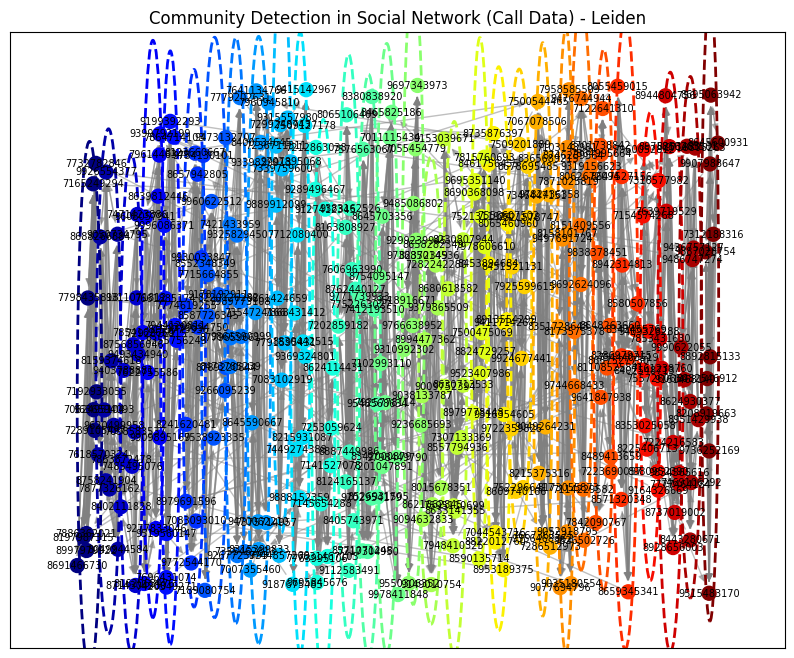

In [39]:
# Visualizing the communities with improved layout
try:
    plt.figure(figsize=(10, 8))

    # Group nodes by community, starting from Community 1
    communities = {}
    for node, community_id in partition.items():
        # Add 1 to the community_id to start from 1 instead of 0
        adjusted_community_id = community_id + 1

        if adjusted_community_id not in communities:
            communities[adjusted_community_id] = []
        communities[adjusted_community_id].append(node)

    # Adjust positions within communities to gather nodes together
    adjusted_pos = {}

    # Increase the proximity between nodes of the same community
    for community_id, nodes in communities.items():
        x_pos = [random.uniform(-1, 1) for _ in nodes]
        y_pos = [random.uniform(-1, 1) for _ in nodes]
        for node, x, y in zip(nodes, x_pos, y_pos):
            adjusted_pos[node] = (x + community_id * 2, y)

    # Nodes colored by community
    num_communities = len(communities)
    cmap = plt.cm.get_cmap('jet', num_communities)
    colors = [cmap(partition[node]) for node in G.nodes()]

    nx.draw_networkx_nodes(G, adjusted_pos, node_color=colors, cmap=plt.cm.jet, node_size=100)

    # Draw directed edges
    nx.draw_networkx_edges(G, adjusted_pos, alpha=0.5, edgelist=G.edges(), arrows=True, edge_color="grey")

    # Draw node labels
    nx.draw_networkx_labels(G, adjusted_pos, font_size=7, font_color="black")

    # Add community borders (using Ellipse for oval/circular shapes)
    for community_id, nodes in communities.items():
        # Get positions of nodes in this community
        community_pos = [adjusted_pos[node] for node in nodes]
        x_coords, y_coords = zip(*community_pos)

        # Calculate center and size of the ellipse
        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)
        width = max(x_coords) - min(x_coords) + 0.5  # Adjust +0.5 for padding
        height = max(y_coords) - min(y_coords) + 0.5  # Adjust +0.5 for padding

        # Get community color (same logic as before)
        if nodes:
            try:
                node_index = list(G.nodes()).index(nodes[0])
                community_color = colors[node_index]
            except ValueError:
                community_color = 'black'
        else:
            community_color = 'black'

        # Create an Ellipse patch
        ellipse = Ellipse(xy=(center_x, center_y), width=width, height=height,
                          edgecolor=community_color, facecolor='none', linestyle='--', lw=2)

        # Add the ellipse to the plot
        plt.gca().add_patch(ellipse)

    plt.title("Community Detection in Social Network (Call Data) - Leiden")
    plt.show()

except Exception as e:
    print(f"An error occurred during visualization: {e}")
    sys.exit(1)  # Exit with an error code

In [40]:
# Displaying the detected communities in sorted order
print(f"Modularity Score: {modularity_score}")
print("Detected Communities (Leiden):")
try:
    for community_id in sorted(communities.keys()):
        members = sorted(communities[community_id])
        print(f"Community {community_id}: {members}")
except KeyError as e:
    print(f"Error: Community ID not found: {e}")
except TypeError as e:
    print(f"Error: Invalid community structure: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Modularity Score: 0.9175547754219108
Detected Communities (Leiden):
Community 1: [7062495104, 7165249294, 7192933055, 7289105497, 7732782846, 7798435818, 7886362021, 8197987315, 8691466730, 8997979922]
Community 2: [7618570324, 7877326162, 8049944584, 8159374618, 8688266884, 8758241904, 9050734795, 9620499958, 9636594093, 9926554377]
Community 3: [7098583537, 7471423886, 7485495076, 7863672478, 8402111828, 8714304980, 8756856046, 9311071812, 9403788881, 9493434940]
Community 4: [7292876915, 7622755586, 7854162650, 7961446349, 8162063476, 8639812446, 9277833046, 9399792199, 9608057941, 9909895169]
Community 5: [7420349271, 7661885174, 7696431074, 7864714103, 7944120811, 8153775936, 9199392293, 9355756243, 9519560147, 9996086371]
Community 6: [7083093010, 7774619255, 8123660667, 8241620481, 8657942805, 8979691596, 9399894750, 9754130101, 9772544170, 9930033847]
Community 7: [7189080754, 7538923335, 7715664855, 8552348349, 8587726345, 8789220844, 9178192911, 9266095239, 9473132707, 996062

In [41]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Ellipse

# Visualization Function
def visualize_communities(communities, G, num1, num2, partition):
    try:
        num1_community = None
        num2_community = None

        # Ensure num1 and num2 exist in the graph
        if num1 not in G.nodes() or num2 not in G.nodes():
            print(f"Error: One or both nodes ({num1}, {num2}) do not exist in the graph.")
            sys.exit(1)

        # Identify which communities num1 and num2 belong to
        for community_id, members in communities.items():
            if num1 in members:
                num1_community = community_id
            if num2 in members:
                num2_community = community_id
            if num1_community is not None and num2_community is not None:
                break  # Stop early if both are found

        if num1_community is None or num2_community is None:
            print(f"Error: One or both nodes ({num1}, {num2}) do not belong to any community.")
            sys.exit(1)

        selected_communities_id = {num1_community, num2_community}
        print(f"Selected Communities: {selected_communities_id}")

        # Extract nodes from the selected communities
        selected_nodes = set()
        for community_id in selected_communities_id:
            if community_id is not None:
                selected_nodes.update(communities[community_id])

        # Ensure there are selected nodes to form a subgraph
        if not selected_nodes:
            print("Error: No nodes found for the selected communities.")
            sys.exit(1)

        # Create a subgraph containing only the selected nodes
        subgraph = G.subgraph(selected_nodes)

        # Filter edges to include only those within or between selected communities
        filtered_edges = []
        for u, v in subgraph.edges():
            u_community = None
            v_community = None
            for community_id, members in communities.items():
                if u in members:
                    u_community = community_id
                if v in members:
                    v_community = community_id
                if u_community is not None and v_community is not None:
                    break
            if u_community in selected_communities_id and v_community in selected_communities_id:
                filtered_edges.append((u, v))

        plt.figure(figsize=(8, 6))

        # Compute separate layouts for each community
        community_positions = {}
        base_x = 0.5  # Offset for community separation
        spacing = 2.5  # Distance between communities

        for i, community_id in enumerate(selected_communities_id):
            if community_id is None:
                continue

            community_nodes = [node for node in communities.get(community_id, []) if node in subgraph.nodes()]
            if not community_nodes:
                continue

            # Generate positions only for this community
            sub_pos = nx.spring_layout(G.subgraph(community_nodes), seed=11, scale=1.0)

            # Offset community positions
            for node, (x, y) in sub_pos.items():
                community_positions[node] = (x + base_x, y)

            base_x += spacing  # Move the next community further right

        # Node colors based on partition
        unique_community_ids = set(partition[node] for node in subgraph.nodes() if node in partition)
        cmap = plt.cm.get_cmap('jet', len(unique_community_ids))
        community_colors = {comm_id: cmap(i) for i, comm_id in enumerate(sorted(unique_community_ids))}
        node_colors = {node: community_colors[partition[node]] for node in subgraph.nodes()}

        # Draw nodes, edges, and labels
        nx.draw_networkx_nodes(subgraph, community_positions, node_color=[node_colors[node] for node in subgraph.nodes()], node_size=200)
        nx.draw_networkx_labels(subgraph, community_positions, font_size=8, font_color="black")

        # Draw edges (using filtered_edges)
        nx.draw_networkx_edges(subgraph, community_positions, alpha=0.5, edgelist=filtered_edges, arrows=True, edge_color="grey")

        # Highlight num1 and num2
        if num1 in community_positions:
            nx.draw_networkx_nodes(subgraph, community_positions, nodelist=[num1], node_color='red', node_size=300)
        if num2 in community_positions:
            nx.draw_networkx_nodes(subgraph, community_positions, nodelist=[num2], node_color='green', node_size=300)

        # Draw ellipses around communities with matching colors
        ax = plt.gca()
        for community_id in selected_communities_id:
            if community_id is None:
                continue

            community_nodes = [node for node in communities.get(community_id, []) if node in community_positions]
            if not community_nodes:
                continue

            community_pos = [community_positions[node] for node in community_nodes]
            x_coords, y_coords = zip(*community_pos)
            center_x = sum(x_coords) / len(x_coords)
            center_y = sum(y_coords) / len(y_coords)
            width = max(x_coords) - min(x_coords) + 0.5
            height = max(y_coords) - min(y_coords) + 0.5

            representative_node = community_nodes[0]
            community_color = node_colors.get(representative_node, "black")

            ellipse = Ellipse(
                xy=(center_x, center_y), width=width, height=height,
                edgecolor=community_color, facecolor='none', linestyle='--', lw=2
            )
            ax.add_patch(ellipse)

        # Add edge weight labels (using filtered_edges)
        edge_weights = nx.get_edge_attributes(subgraph, 'weight')
        filtered_edge_weights = {edge: edge_weights[edge] for edge in filtered_edges if edge in edge_weights}  # Filter edge weights
        nx.draw_networkx_edge_labels(subgraph, community_positions, edge_labels=filtered_edge_weights, font_color='blue', font_size=8)

        plt.title(f"Communities of {num1} and {num2}")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
        sys.exit(1)


In [42]:
# Search Function
def get_common_community(communities, num1, num2, G, partition):
    try:
        num1_community = None
        num2_community = None

        # Find the community for each number
        for community_id, mob in communities.items():
            if num1 in mob:
                num1_community = community_id
            if num2 in mob:
                num2_community = community_id
            if num1_community is not None and num2_community is not None:
                break  # Stop early if both are found

        # Check if both numbers are in the same community
        if num1_community == num2_community and num1_community is not None:
            print(f"Numbers {num1} and {num2} belong to the same community (Community {num1_community}).")
            visualize_communities(communities, G, num1, num2, partition)  # Call to visualize_communities if they are in the same community
            return num1_community  # Same Community
        else:
            print(f"Numbers {num1} and {num2} belong to different communities.")
            if num1_community is not None:
                print(f"Number {num1} is in Community {num1_community}.")
            else:
                print(f"Number {num1} was not found in any community.")
            if num2_community is not None:
                print(f"Number {num2} is in Community {num2_community}.")
            else:
                print(f"Number {num2} was not found in any community.")
            visualize_communities(communities, G, num1, num2, partition)  # Still visualize even if they are in different communities
            return None  # Different Communities

    except (TypeError, KeyError) as e:
        print(f"Error: Invalid input or community structure: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


Enter the first number: 7316577982
Enter the second number: 7853431630
Number 1: 7316577982
Number 2: 7853431630
Numbers 7316577982 and 7853431630 belong to different communities.
Number 7316577982 is in Community 27.
Number 7853431630 is in Community 28.
Selected Communities: {27, 28}


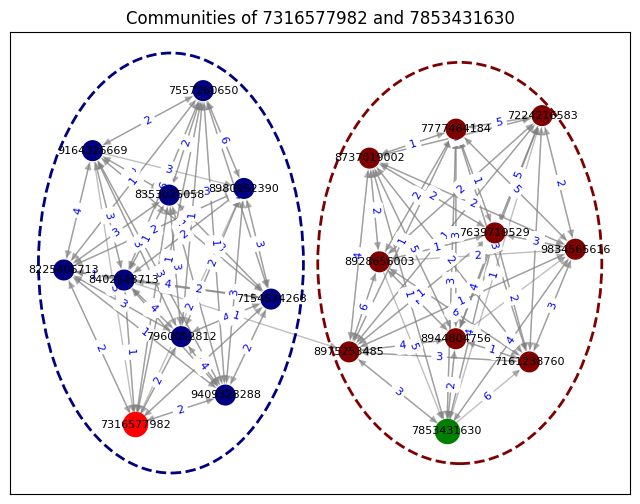

In [43]:
# Search and Visualization Function Call

while True:
    try:
        num1 = int(input("Enter the first number: "))
        num2 = int(input("Enter the second number: "))
        break
    except ValueError:
        print("Error: Invalid input. Please enter numbers only.")
    except Exception as e:
        print(f"An unexpected error occurred during input: {e}")

print(f"Number 1: {num1}")
print(f"Number 2: {num2}")
call = get_common_community(communities, num1, num2, G, partition)
#Number 1: 7316577982
#Number 2: 7853431630